## Bayes Factors

Based on https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Bayes_factor.html

In [1]:
%pip install pymc pytensor

In [2]:
import arviz as az
import numpy as np
import pymc as pm

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.special import betaln
from scipy.stats import beta

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.4


Let's consider the coin flipping problem, and let's use the Binomial/Beta model.

Let's consider two priors, with parameters (1,1) and (30,30) for α and β

In [8]:
y = np.repeat([1, 0], [50, 50])  # 50 "heads" and 50 "tails" # NOTICE THIS MEANS WE HAVE A FAIR COIN!
priors = ((1, 1), (30, 30)) # What model is going to be best?

In [6]:
models = []
idatas = []
for alpha, beta in priors:
    with pm.Model() as model:
        a = pm.Beta("a", alpha, beta)
        yl = pm.Bernoulli("yl", a, observed=y)
        idata = pm.sample_smc(random_seed=42)
        models.append(model)
        idatas.append(idata)

/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:221: UserWarning: More chains (2) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Let's calculate the Bayes factors

In [9]:
BF_smc = np.exp(
    idatas[1].sample_stats["log_marginal_likelihood"].mean()
    - idatas[0].sample_stats["log_marginal_likelihood"].mean()
)
np.round(BF_smc).item()

5.0

We see that the model with the more concentrated prior beta(30,30) has $\sim$5 times more support than the model with the more extended prior beta(1,1).

Besides the exact numerical value this should not be surprising since the prior for the most favoured model is concentrated around $\theta=$0.5 and the data has equal number of head and tails, consistent with a value of $\theta$ around 0.5.

### Bayes Factor and Inference

So far we have used Bayes factors to judge which model seems to be better at explaining the data, and we get that one of the models is $\approx$ 5 times better than the other.

But what about the posterior we get from these models? How different they are?

In [10]:
az.summary(idatas[0], var_names="a", kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
a,0.5,0.05,0.41,0.59


In [11]:
az.summary(idatas[1], var_names="a", kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
a,0.5,0.04,0.42,0.57


We may argue that the results are pretty similar, we have the same mean value for $\theta$, and a slightly wider posterior for model_0, as expected since this model has a wider prior. We can also check the posterior predictive distribution to see how similar they are.

In [12]:
ppc_0 = pm.sample_posterior_predictive(idatas[0], model=models[0]).posterior_predictive
ppc_1 = pm.sample_posterior_predictive(idatas[1], model=models[1]).posterior_predictive

In [14]:
ppc_0

<xarray.Dataset>
Dimensions:   (chain: 2, draw: 2000, yl_dim_2: 100)
Coordinates:
  * chain     (chain) int64 0 1
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * yl_dim_2  (yl_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    yl        (chain, draw, yl_dim_2) int64 0 0 1 1 0 1 0 1 ... 1 0 1 1 0 0 0 0
Attributes:
    created_at:                 2024-03-07T18:02:21.186088
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4

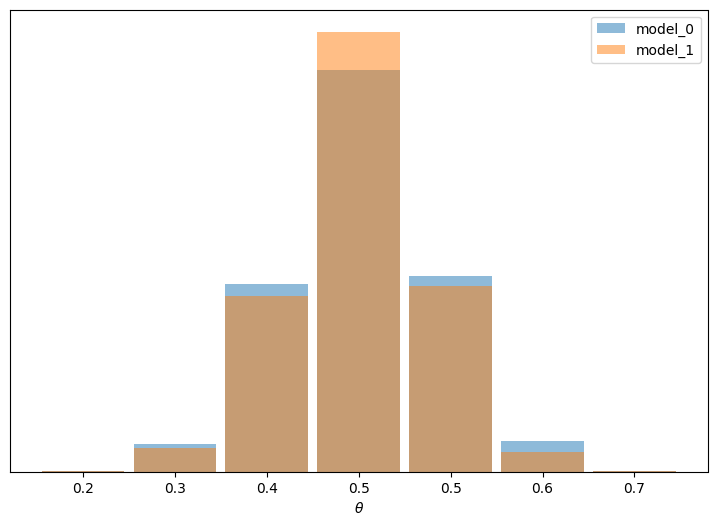

In [16]:
_, ax = plt.subplots(figsize=(9, 6))

bins = np.linspace(0.2, 0.8, 8)

# Computes the mean of the "yl" variable across a specific dimension, "yl_dim_2"
ax = az.plot_dist(
    ppc_0["yl"].mean("yl_dim_2"),
    label="model_0",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
)


ax = az.plot_dist(
    ppc_1["yl"].mean("yl_dim_2"),
    label="model_1",
    color="C1",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
    ax=ax,
)
ax.legend()
ax.set_xlabel("$\\theta$")
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax.set_yticks([]);

In this example the observed data
 is more consistent with model_1 (because the prior is concentrated around the correct value of $\theta$
) than model_0 (which assigns equal probability to every possible value of $\theta$), and this difference is captured by the Bayes factor.

We could say **Bayes factors are measuring which model, as a whole, is better, including details of the prior that may be irrelevant for parameter inference**. In fact in this example we can also see that it is possible to have two different models, with different Bayes factors, but *nevertheless get very similar predictions*.